In [1]:
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon, mannwhitneyu, ranksums
from statsmodels.stats.multitest import multipletests
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy as hcluster
from scipy.spatial.distance import squareform

This notebook, gives a small demo of analyzing the results of the compass algorithm and replicates figures 2E and 2C from the paper.

The file "extdata/Th17/reactions.tsv" is the outputs of a compass run and "extdata/Th17/cell_metadata.csv" is cell metadata, in this case it is only used to know the condition of the cells.

In [2]:
reactions = pd.read_csv("extdata/Th17/reactions.tsv", sep="\t", index_col = 0)

In [3]:
cell_metadata = pd.read_csv("extdata/Th17/cell_metadata.csv", index_col = 0)

In [4]:
Th17p_cells = cell_metadata.index[cell_metadata['cell_type'] == 'Th17p']
Th17n_cells = cell_metadata.index[cell_metadata['cell_type'] == 'Th17n']

The reaction metadata for RECON2 is stored here. We'll be using the confidence scores and the subsystem groupings to filter out reactions and group them for analysis.

In [5]:
reaction_metadata = pd.read_csv("extdata/RECON2/reaction_metadata.csv", index_col = 0) 

In [6]:
def cohens_d(x, y):
    pooled_std = np.sqrt(((len(x)-1) * np.var(x, ddof=1) 
                          + (len(y)-1) * np.var(y, ddof=1)) / 
                             (len(x) + len(y) - 2))
    return (np.mean(x) - np.mean(y)) / pooled_std
    

def wilcoxon_test(consistencies_matrix, group_A_cells, group_B_cells):
    """
        Performs an unpaired wilcoxon test (or mann-whitney U test) for each reaction between group_A and group_B
    """
    #per reaction/meta-reaction, conduct wilcoxon test between group_A and group_B
    group_A = consistencies_matrix.loc[:,group_A_cells]
    group_B = consistencies_matrix.loc[:,group_B_cells]
    results = pd.DataFrame(index = consistencies_matrix.index, columns = ['wilcox_stat', 'wilcox_pval', 'cohens_d'], dtype='float64')
    for rxn in consistencies_matrix.index:
        A, B = group_A.loc[rxn].to_numpy().ravel(), group_B.loc[rxn].to_numpy().ravel()
        stat, pval = mannwhitneyu(A, B, alternative='two-sided')
        c_d = cohens_d(A, B)
        results.loc[rxn, ['wilcox_stat', 'wilcox_pval', 'cohens_d']] = stat, pval, c_d
    results['adjusted_pval'] = np.array(multipletests(results['wilcox_pval'], method='fdr_bh')[1], dtype='float64')
    return results

In [7]:
def get_reaction_consistencies(compass_reaction_scores, min_range=1e-3):
    df = -np.log(compass_reaction_scores + 1)
    df = df[df.max(axis=1) - df.min(axis=1) >= 1e-3]
    df = df - df.min().min()
    return df

The numbers in the reactions tsv correspond to penalties for each reaction per cell, so we take the negative log to get scores that correspond to a reaction being predicted to be more active and put them in the reaction consistencies matrix. This also drops reactions that are close to constant and therefore not informative for the comparison.

In [8]:
reactions[reactions <= 1e-4] = 0
reactions = reactions[np.any(reactions != 0, axis=1)]

In [9]:
reactions = reactions[reactions.max(axis=1) - reactions.min(axis=1) != 0]

In [10]:
reactions.shape

(6563, 290)

We group reactions into metareactions using heirarchical clustering as detailed in the manuscript (TBD: Allon might want to add something here)

In [11]:
#pairwise_reaction_correlations = reactions.T.corr(method='spearman') #Pandas method here is orders of magnitude slower
pairwise_reaction_correlations = np.corrcoef(reactions.rank(axis=1))
#Unfortunately due to floating point issues, numpy notes this matrix may not be symmetric. This should fix that
#It also looks like some entries on the diagonal are slightly less than 1, such as 1 - 1e-16
pairwise_reaction_correlations[np.arange(reactions.shape[0]), np.arange(reactions.shape[0])] = 1.0
pairwise_reaction_correlations = (pairwise_reaction_correlations + pairwise_reaction_correlations.T)/2

In [12]:
assert(np.all(pairwise_reaction_correlations == pairwise_reaction_correlations.T))

In [13]:
Z = hcluster.complete(squareform(1 - pairwise_reaction_correlations))

In [14]:
#Verified this is the same number of clusters as the original paper
meta_rxns_map = hcluster.fcluster(Z, 0.02, criterion='distance')
meta_rxns = reactions.join(pd.DataFrame(meta_rxns_map, columns=["meta_rxn_id"], index = reactions.index)).groupby("meta_rxn_id").mean()

In [15]:
meta_rxn_consistencies = get_reaction_consistencies(meta_rxns)

In [16]:
wilcox_meta_rxn_results = wilcoxon_test(meta_rxn_consistencies, Th17p_cells, Th17n_cells)

In [17]:
wilcox_meta_rxn_results

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval
meta_rxn_id,,,,
1,4172.0,7.900994e-19,-1.261458,1.360551e-16
2,3536.0,1.793158e-22,-1.374285,6.175636e-20
3,4912.0,5.110311e-15,-1.012496,5.866637e-13
4,3574.0,3.026482e-22,-1.417214,8.686003e-20
5,4977.0,1.049939e-14,-0.919333,1.063526e-12
...,...,...,...,...
1907,12093.0,2.509862e-02,0.222403,5.207208e-02
1908,13603.0,1.322099e-05,0.304340,8.963205e-05
1909,13475.0,2.953785e-05,0.369517,1.753937e-04


In [18]:
wilcox_results = pd.DataFrame(index=reactions.index, columns=wilcox_meta_rxn_results.columns)
for i in range(len(wilcox_results.index)):
    if (meta_rxns_map[i] in wilcox_meta_rxn_results.index):
        wilcox_results.loc[wilcox_results.index[i]] = wilcox_meta_rxn_results.loc[meta_rxns_map[i]]
wilcox_results = wilcox_results.dropna().astype('float64')

In [19]:
wilcox_results['metadata_r_id'] = ""
for r in wilcox_results.index:
    if r in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r
    elif r[:-4] in reaction_metadata.index:
        wilcox_results.loc[r, 'metadata_r_id'] = r[:-4]
    else:
        print("Should not occur")

Adding metadata to the dataframe and removing reactions with confidence other than 0, or 4 and filtering out reactions in the citric acid cycle subsystem which are outside of the mitochondria.

In [20]:
W = wilcox_results.merge(reaction_metadata, how='left', 
                         left_on='metadata_r_id', right_index=True, validate='m:1')
W = W[W['confidence'].isin([0,4])]
W = W[~W['EC_number'].isna()]
W.loc[(W['formula'].map(lambda x: '[m]' not in x)) & (W['subsystem'] == "Citric acid cycle"), 'subsystem'] = 'Other'

Here is one example of a row of the reuslting dataframe for a reaction:

In [21]:
wilcox_results.loc[['r0281_neg']]

,wilcox_stat,wilcox_pval,cohens_d,adjusted_pval,metadata_r_id
r0281_neg,701.0,3.496712e-49,-1.204218,2.007113e-46,r0281


# Fig 2C replication

In [22]:
labeled_reactions = {
    "PGM_neg" : "phosphoglycerate mutase (PGAM)",
    "LDH_L_neg" : "lactate dehydrogenase",
    "PDHm_pos" : "pyruvate dehydrogenase (PDH)",
    "TPI_neg" : "triosephosphate isomerase (DHAP forming)",
    "FACOAL1821_neg" : "long-chain fatty-acid-CoA ligase",
    "r1257_pos" : "long-chain fatty-acid-CoA ligase",
    "FACOAL1831_neg" : "long-chain fatty-acid-CoA ligase",
    "CSNATr_neg" : "carnitine O-acetyltransferase",
    "C160CPT1_pos" : "carnitine O-palmitoyltransferase",
    "ACONTm_pos" : "aconitate hydratase",
    "SUCOASm_pos" : "succinate-CoA ligase",
    "AKGDm_pos" : "alpha-ketoglutarate dehydrogenase",
    "SUCD1m_pos" : "succinate dehydrogenase",
    "ICDHyrm_pos" : "isocitrate dehydrogenase",
    "CK_pos" : "creatine\nkinase",
    "PGCD_pos" : "phosphoglycerate dehydrogenase",
    "ARGSS_pos" : "arginosuccinate synthase",
    "r0281_neg" : "putrescine diamine oxidase",
    "SPMDOX_pos" : "spermidine dehydrogenase (spermidine -> GABA)",
    "ARGDCm_pos" : "arginine decarboxylase",
    "AGMTm_pos" : "agmatinase",
    "GHMT2r_pos" : "serine hydroxymethyltransferase",
    "AHC_pos" : "adenosylhomocysteinase",
    "METAT_pos" : "methionine adenosyltransferase",
    "METS_pos" : "methionine\nsynthase",
    "ARGN_pos" : "arginase"
}

In [23]:
def plot_differential_scores(data, title, c):
    plt.figure(figsize=(10,10))
    axs = plt.gca()
    axs.scatter(data['cohens_d'], -np.log10(data['adjusted_pval']), c=c)
    axs.set_xlabel("Cohen's d", fontsize=16)
    axs.set_ylabel("-log10 (Wilcoxon-adjusted p)", fontsize=16)
    #Everything after this should be tweaked depending on your application
    axs.set_xlim(-2.2, 2.2)
    axs.axvline(0, dashes=(3,3), c='black')
    axs.axhline(1, dashes=(3,3), c='black')
    axs.set_title(title, fontdict={'fontsize':20})
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(0, -0.08), 
            arrowprops=dict(arrowstyle="<-", color='#348C73', linewidth=4))
    axs.annotate('Th17p', xy=(0.75, -0.12), xycoords='axes fraction', fontsize=16)
    axs.annotate('', xy=(0.5, -0.08), xycoords='axes fraction', xytext=(1, -0.08), 
            arrowprops=dict(arrowstyle="<-", color='#E92E87', linewidth=4))
    axs.annotate('Th17n', xy=(0.25, -0.12), xycoords='axes fraction', fontsize=16)
    for r in data.index:
        if r in labeled_reactions:
            x = data.loc[r, 'cohens_d']
            y = -np.log10(data.loc[r, 'adjusted_pval'])
            offset = (20, 0)
            if x < 0:
                offset = (-100, -40)
            axs.annotate(labeled_reactions[r], (x,y), xytext = offset, 
                         textcoords='offset pixels', arrowprops={'arrowstyle':"-"})

In [24]:
amino_acid_metab = ["Alanine and aspartate metabolism",
            "Arginine and Proline Metabolism",
            "beta-Alanine metabolism",
            "Cysteine Metabolism",
            "D-alanine metabolism",
            "Folate metabolism",
            "Glutamate metabolism",
            "Glycine, serine, alanine and threonine metabolism",
            "Histidine metabolism",
            "Lysine metabolism",
            "Methionine and cysteine metabolism",
            "Taurine and hypotaurine metabolism",
            "Tryptophan metabolism",
            "Tyrosine metabolism",
            "Urea cycle",
            "Valine, leucine, and isoleucine metabolism"]

In [25]:
filtered_data = pd.concat([W[W['subsystem'] == "Glycolysis/gluconeogenesis"],
             W[W['subsystem'] == "Citric acid cycle"],
            W[W['subsystem'].isin(amino_acid_metab)],
           W[W['subsystem'] == "Fatty acid oxidation"]])

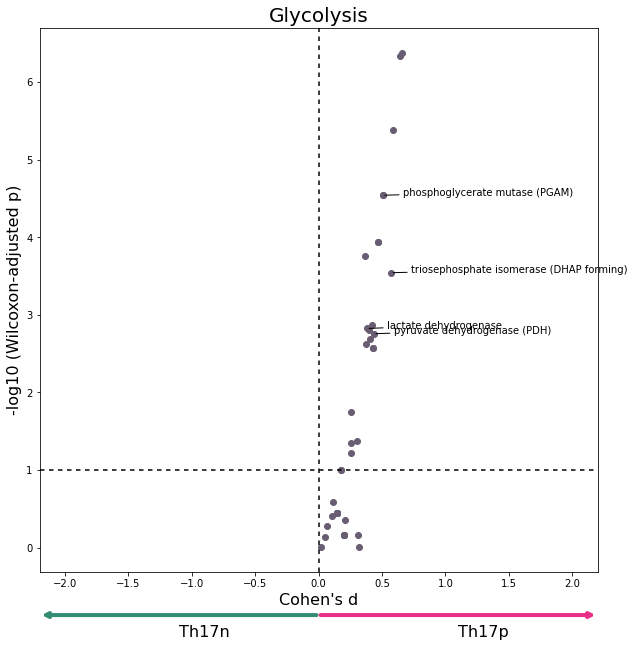

In [26]:
data = W[W['subsystem'] == "Glycolysis/gluconeogenesis"]
plot_differential_scores(data, title='Glycolysis', c="#695D73")

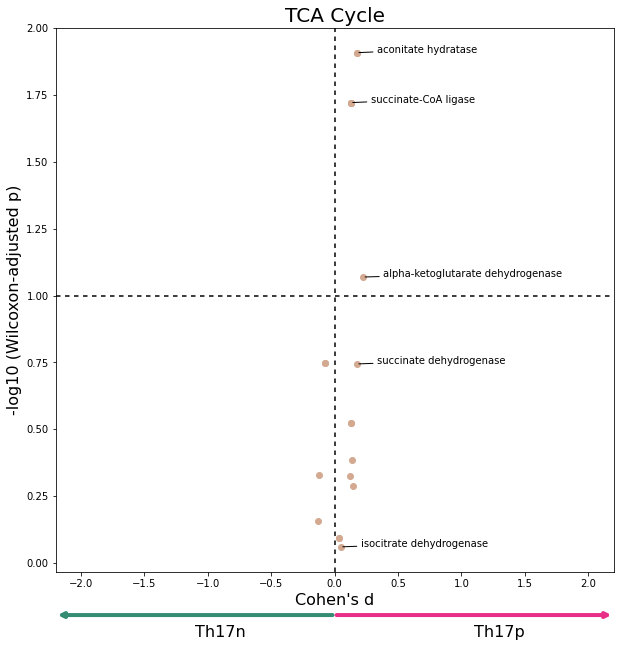

In [27]:
data = W[W['subsystem'] == "Citric acid cycle"]
plot_differential_scores(data, title="TCA Cycle", c="#D3A991")

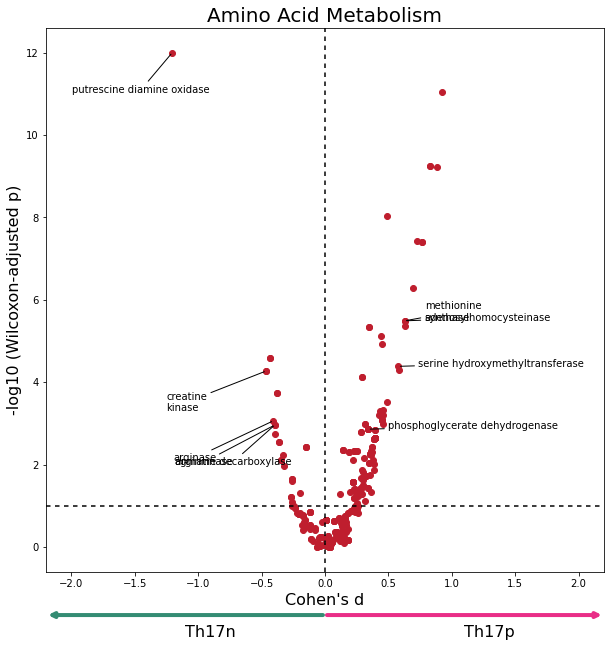

In [28]:
data = W[W['subsystem'].isin(amino_acid_metab)].copy()
data['adjusted_pval'] = data['adjusted_pval'].clip(1e-12)
plot_differential_scores(data, "Amino Acid Metabolism", c="#BF1E2E")

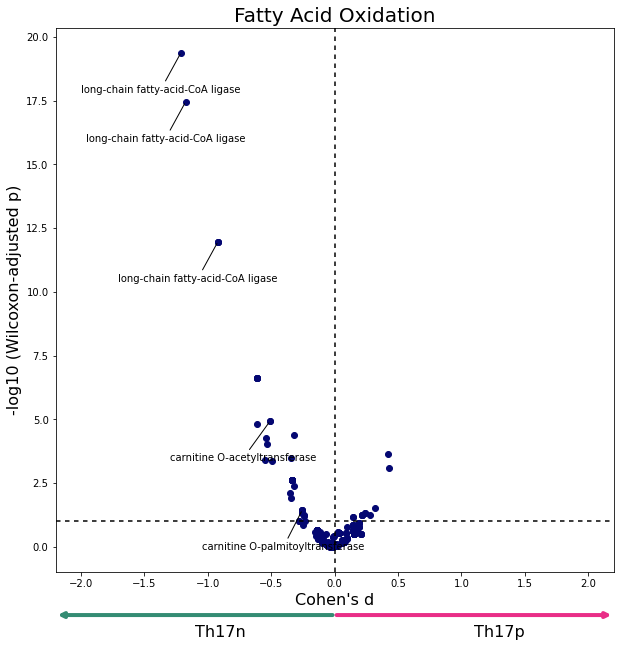

In [29]:
data = W[W['subsystem'] == "Fatty acid oxidation"]
plot_differential_scores(data, "Fatty Acid Oxidation", c="#040772")

Figure 2E stuff

In [30]:
data = W[~W['subsystem'].isin(["Miscellaneous", "Unassigned"])]
data = data[~data['subsystem'].map(lambda x: "Transport" in x or "Exchange" in x or x == "Other")]
items, counts = np.unique(data['subsystem'], return_counts=True)
items = [items[i] for i in range(len(items)) if counts[i] > 5] #filter(n() > 5) %>%
data = data[data['subsystem'].isin(items)]

Text(0.5, 0, "Cohen's d")

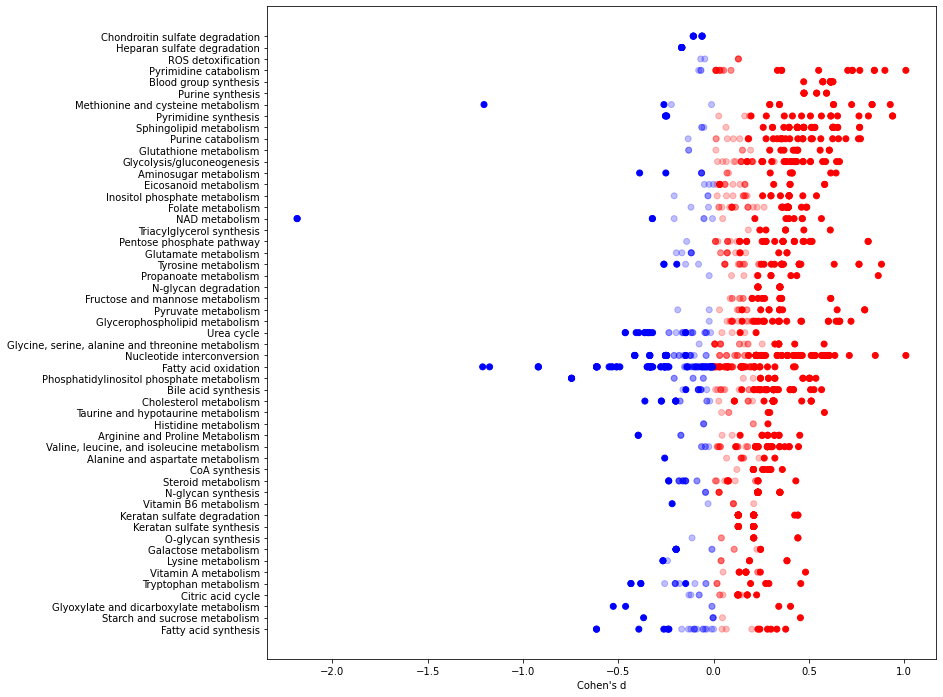

In [31]:
plt.figure(figsize=(12,12))
axs = plt.gca()
#Sorts the reactions for plotting
d = data[data['adjusted_pval'] < 0.1].groupby('subsystem')['cohens_d'].median().abs()
axs.scatter(d[d.argsort], d[d.argsort].index, alpha=0)
color = data['cohens_d'].map(lambda x: 'r' if x >= 0 else 'b')
alpha = data['adjusted_pval'].map(lambda x: 1 if x < 0.1 else 0.25)
axs.scatter(data['cohens_d'], data['subsystem'], c=color, alpha=alpha)
axs.set_xlabel("Cohen's d")